<a href="https://colab.research.google.com/github/El-amin/HauwBert-A-Transformer-Based-Model-For-Aspect-Based-Sentiment-Analysis-ABSA-/blob/main/HauBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets scikit-learn

import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForTokenClassification, BertForSequenceClassification
from transformers import AdamW
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.metrics import classification_report
import numpy as np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
# Load the movie comments dataset
#pd.read_csv('movie_comments.csv')
movie_comments=pd.read_csv('movie_comments.csv')

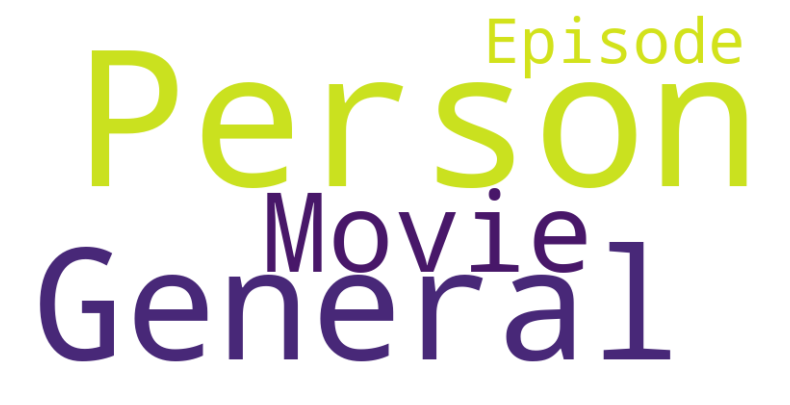

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sample text
#text = "Data Science is fun and powerful. Learning data science helps build the future."

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(movie_comments['Aspect_words(persons, movie, episode,general)'].str.cat(sep=' '))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
# prompt: Using dataframe movie_comments: table view

movie_comments



,Comment,"Aspect_words(persons, movie, episode,general)",Polarity
0,Nakowa is seriously funny,Person,Neutral
1,This series is becoming so boring wallahi,Movie,Negative
2,Nakowa,Person,Neutral
3,Ta yaya suka san abunda ke faruwa bayan basa c...,Person,Neutral
4,Masha Allah Na kowa namu,Person,Positive
...,...,...,...
645,Ya labarin cikin hajia Sara,Person,Neutral
646,Allah ya Kara basira,General,Neutral
647,Wai kenan har yanzu ana izzar so kam amma ansh...,Movie,Negative
648,Wow uwa taga danta real aliyu matawale,Person,Positive


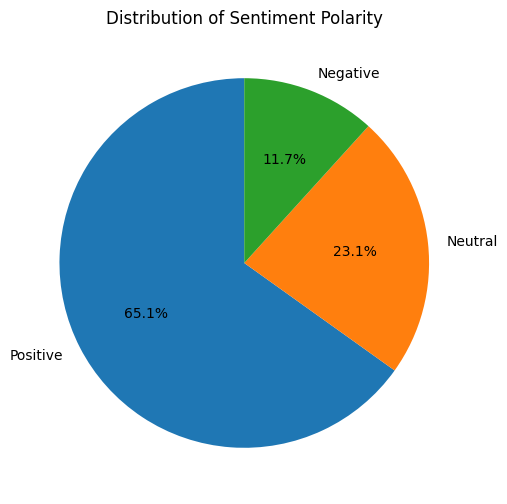

In [ ]:
# @title Distribution of Sentiment Polarity

import matplotlib.pyplot as plt

# Assuming your data is in a pandas DataFrame called 'df'

polarity_counts = df['Polarity'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=90)
_ = plt.title('Distribution of Sentiment Polarity')


In [ ]:
# @title Sentiment Polarity by Aspect

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assuming your data is in a pandas DataFrame called 'df'

plt.figure(figsize=(10, 6))
sns.countplot(x='Aspect_words(persons, movie, episode,general)', hue='Polarity', data=df)
plt.title('Sentiment Polarity by Aspect')
plt.xlabel('Aspect')
plt.ylabel('Count')
_ = plt.xticks(rotation=45, ha='right')


In [ ]:
# Cleaning polarity labels and standardizing text
# Remove extra spaces in polarity labels and lowercasing comments for consistency
import re
def remove_emojis(text):
  emoji_pattern = re.compile(
                            "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"  # Alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric shapes
        u"\U0001F800-\U0001F8FF"  # Supplemental symbols
        u"\U0001F900-\U0001F9FF"  # Supplemental symbols
        u"\U0001FA00-\U0001FA6F"  # Chess symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols for clothing, etc.
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed characters
        u"\U00010000-\U0010FFFF"  # Supplementary Planes (newer emojis)
        "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)

movie_comments['Comment'] = movie_comments['Comment'].apply(remove_emojis)


movie_comments['Polarity'] = movie_comments['Polarity'].str.strip()  # Remove extra spaces
movie_comments['Aspect_words(persons, movie, episode,general)'].str.strip().str.lower().str.replace(r'[^\w\s]','', regex=True)  # Remove punctuation

movie_comments['Comment'] = movie_comments['Comment'].str.strip().str.lower()  # Normalize text
movie_comments.dropna(subset=['Polarity'], inplace=True)
movie_comments.dropna(subset=['Aspect_words(persons, movie, episode,general)'], inplace=True)
# Check for NaN values in polarity and comments
missing_polarity = movie_comments['Polarity'].isna().sum()
missing_comments = movie_comments['Comment'].isna().sum()
missing_aspect=movie_comments['Aspect_words(persons, movie, episode,general)'].isna().sum()

# Display a sample of cleaned data
cleaned_sample = movie_comments.sample(5, random_state=42)

missing_polarity, missing_comments, missing_aspect, cleaned_sample


(0,
 0,
 0,
                                                Comment  \
 637        mash allah watching from  congo brazzaville   
 220                        masha allah barka da dayowa   
 595                         mastha  allah allahu rabbi   
 430  ya kamata ku canza wa shirinn suna <br>dan ba ...   
 72                  alhamdulilah izzar so has continue   
 
     Aspect_words(persons, movie, episode,general)  Polarity  
 637                                       General  Positive  
 220                                         Movie  Positive  
 595                                       General  Positive  
 430                                         Movie  Negative  
 72                                          Movie  Positive  )

In [ ]:
# Remove extra spaces, convert to lowercase, and clean text in 'Aspect_words(persons, movie, episode, general)'
movie_comments['Aspect_words(persons, movie, episode,general)']= (
   movie_comments['Aspect_words(persons, movie, episode,general)']
    .str.strip()  # Remove leading and trailing spaces
    .str.lower()  # Convert to lowercase
    .str.replace(r'[^\w\s]', '', regex=True)  # Remove punctuation
    .str.replace(r'\s+', ' ', regex=True)  # Replace multiple spaces with a single space
)

# Remove trailing periods and extra spaces in all columns
movie_comments = movie_comments.applymap(
    lambda x: x.strip().rstrip('.') if isinstance(x, str) else x
)

# Normalize text in 'Comment' column
movie_comments['Comment'] = (
    movie_comments['Comment']
    .str.strip()  # Remove leading and trailing spaces
    .str.lower()  # Convert to lowercase
    .str.replace(r'[^\w\s]', '', regex=True)  # Remove punctuation
    .str.replace(r'\s+', ' ', regex=True)  # Replace multiple spaces with a single space
)


<ipython-input-7-3034dd32793a>:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  movie_comments = movie_comments.applymap(


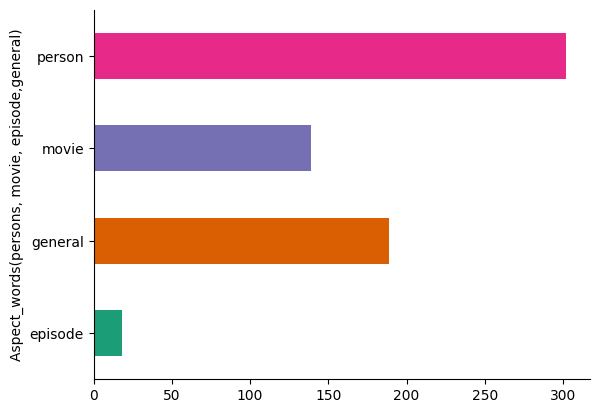

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
movie_comments.groupby('Aspect_words(persons, movie, episode,general)').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

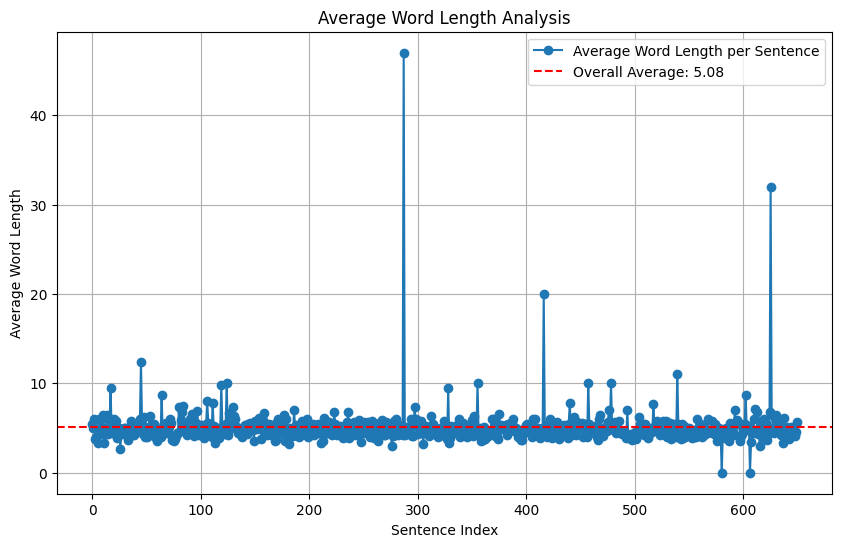

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Handle missing or non-string values
movie_comments['Comment'] = movie_comments['Comment'].fillna('').astype(str)

# Calculate word lengths for each sentence
movie_comments['word_lengths'] = movie_comments['Comment'].apply(lambda x: [len(word) for word in x.split()])

# Calculate average word length per row (avoid division by zero)
movie_comments['average_word_length'] = movie_comments['word_lengths'].apply(
    lambda x: sum(x) / len(x) if len(x) > 0 else 0
)

# Calculate the overall average word length
overall_average_word_length = movie_comments['average_word_length'].mean()

# Plot average word length for each row
plt.figure(figsize=(10, 6))
plt.plot(
    movie_comments.index,
    movie_comments['average_word_length'],
    marker='o',
    label='Average Word Length per Sentence'
)
plt.axhline(
    y=overall_average_word_length,
    color='r',
    linestyle='--',
    label=f'Overall Average: {overall_average_word_length:.2f}'
)
plt.xlabel('Sentence Index')
plt.ylabel('Average Word Length')
plt.title('Average Word Length Analysis')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:

# Define a mapping function to convert the polarity labels
def encode_polarity(polarity):
    mapping = {
        'positive': 1,
        'neutral': 0,
        'negative': 2
    }
    return mapping.get(polarity.strip().lower(), -1)  # Default to -1 for any unknown labels

# Apply the encoding function to the 'Polarity' column
movie_comments['Polarity_encoded'] = movie_comments['Polarity'].apply(encode_polarity)

# Display the encoded polarity column
print(movie_comments[['Polarity', 'Polarity_encoded']].head())


   Polarity  Polarity_encoded
0   Neutral                 0
1  Negative                 2
2   Neutral                 0
3   Neutral                 0
4  Positive                 1


In [ ]:


# Example list of common Hausa names (expand this list with actual names as needed)
hausa_names = [
    "ali", "nuhu", "ahmed", "fatimah", "musa", "aisha", "sulaiman", "yasmin", "tijjani" "Umar", "Jibril", "Karima" "Nazir",
    # Add more names as needed
]

# Updated aspect categorization function based on content and name matching
def annotate_aspect(comment, aspect_category):
    """
    Annotates a comment with BIO tags based on aspect categories.

    Args:
        comment (str): The input comment.
        aspect_category (str): The aspect category ('General', 'Person', 'Movie').

    Returns:
        dict: Tokenized words and their BIO tags.
    """
    words = comment.split()
    tags = []

    # Check the aspect category based on the given aspect_category
    if aspect_category == "General":
        tags = ['B-General'] + ['I-General'] * (len(words) - 1)
    elif aspect_category == "Person":
        tags = ['B-Person'] + ['I-Person'] * (len(words) - 1)
    elif aspect_category == "Movie":
        tags = ['B-Movie'] + ['I-Movie'] * (len(words) - 1)
    elif aspect_category == "Episode":
        tags = ['B-Episode'] + ['I-Episode'] * (len(words) - 1)
    else:
        tags = ['O'] * len(words)  # Other case if the category is unknown

    return {"words": words, "tags": tags}

# Function to determine aspect category based on content and name list matching
def determine_aspect_category(comment):
    """
    Determines the aspect category of a comment based on simple keyword matching and name list.

    Args:
        comment (str): The input comment.

    Returns:
        str: The aspect category ('General', 'Person', 'Movie', 'Episode').
    """
    words = comment.split()

    # Check if any word in the comment is in the Hausa names list
    for word in words:
        if word.lower() in hausa_names:
            return "Person"

    # Simple keyword-based matching for movie, episode, or general
    if "movie" in comment or "film" in comment:
        return "Movie"
    elif "episode" in comment:
        return "Episode"
    else:
        return "General"

# Apply aspect annotation based on content and name matching
df = pd.DataFrame(movie_comments)  # Assuming movie_comments is already loaded into a DataFrame

# Create a new column to store annotations
df['Annotations'] = [
    annotate_aspect(comment, determine_aspect_category(comment))
    for comment in df['Comment']
]

# Display the annotated data
for index, row in df.iterrows():
    print(f"Comment: {row['Comment']}")
    print(f"Words: {row['Annotations']['words']}")
    print(f"Tags: {row['Annotations']['tags']}")
    print()



Comment: nakowa is seriously funny
Words: ['nakowa', 'is', 'seriously', 'funny']
Tags: ['B-General', 'I-General', 'I-General', 'I-General']

Comment: this series is becoming so boring wallahi
Words: ['this', 'series', 'is', 'becoming', 'so', 'boring', 'wallahi']
Tags: ['B-General', 'I-General', 'I-General', 'I-General', 'I-General', 'I-General', 'I-General']

Comment: nakowa
Words: ['nakowa']
Tags: ['B-General']

Comment: ta yaya suka san abunda ke faruwa bayan basa ciki daga wa inda umar ya kira à office kinsa
Words: ['ta', 'yaya', 'suka', 'san', 'abunda', 'ke', 'faruwa', 'bayan', 'basa', 'ciki', 'daga', 'wa', 'inda', 'umar', 'ya', 'kira', 'à', 'office', 'kinsa']
Tags: ['B-General', 'I-General', 'I-General', 'I-General', 'I-General', 'I-General', 'I-General', 'I-General', 'I-General', 'I-General', 'I-General', 'I-General', 'I-General', 'I-General', 'I-General', 'I-General', 'I-General', 'I-General', 'I-General']

Comment: masha allah na kowa namu
Words: ['masha', 'allah', 'na', 'kowa'

In [ ]:
def annotate_aspect_refined(comment, aspects):
    """
    Refines BIO tagging for a comment based on specific aspect terms.

    Args:
        comment (str): The input comment.
        aspects (list): List of tuples (aspect_term, aspect_category).
                        Example: [("actor", "Person"), ("kyau", "Movie")]

    Returns:
        dict: Tokenized words and their refined BIO tags.
    """
    words = comment.split()
    tags = ["O"] * len(words)  # Default to 'O' for all words

    for aspect_term, aspect_category in aspects:
        aspect_words = aspect_term.split()
        for i, word in enumerate(words):
            # Match the beginning of an aspect term
            if word == aspect_words[0] and words[i:i + len(aspect_words)] == aspect_words:
                tags[i] = f"B-{aspect_category}"  # Beginning of aspect
                for j in range(1, len(aspect_words)):
                    tags[i + j] = f"I-{aspect_category}"  # Inside aspect

    return {"words": words, "tags": tags}

# Refine tagging with specific aspects
refined_data = [
    annotate_aspect_refined("actor yayi kyau sosai.", [("actor", "Person"), ("kyau", "Movie")]),
    annotate_aspect_refined("film din yayi kyau sosai.", [("film", "Movie"), ("kyau", "Movie")]),
    annotate_aspect_refined("masha allah ina farin ciki.", [("farin ciki", "General")]),
]

# Display refined annotations
for entry in refined_data:
    print(f"Comment: {' '.join(entry['words'])}")
    print(f"Words: {entry['words']}")
    print(f"Tags: {entry['tags']}")
    print()


Comment: actor yayi kyau sosai.
Words: ['actor', 'yayi', 'kyau', 'sosai.']
Tags: ['B-Person', 'O', 'B-Movie', 'O']

Comment: film din yayi kyau sosai.
Words: ['film', 'din', 'yayi', 'kyau', 'sosai.']
Tags: ['B-Movie', 'O', 'O', 'B-Movie', 'O']

Comment: masha allah ina farin ciki.
Words: ['masha', 'allah', 'ina', 'farin', 'ciki.']
Tags: ['O', 'O', 'O', 'O', 'O']



In [ ]:

# Split into train and test sets
train_texts, test_texts, train_aspects, test_aspects, train_sentiments, test_sentiments = train_test_split(
    df["Comment"], df["Annotations"], movie_comments["Polarity_encoded"], test_size=0.2, random_state=42
)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict({
    "comments": train_texts,
    "annotations": train_aspects,
    "polarity_encoded": train_sentiments
})
test_dataset = Dataset.from_dict({
    "comments": test_texts,
    "annotations": test_aspects,
    "polarity_encoded": test_sentiments
})


In [ ]:
train_dataset


Dataset({
    features: ['comments', 'annotations', 'polarity_encoded'],
    num_rows: 518
})

In [ ]:
# Load mBERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Load models for token classification (aspect extraction) and sequence classification (sentiment polarity)
aspect_model = BertForTokenClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=5  # Labels: B-Aspect, I-Aspect, O
)

sentiment_model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=3  # Sentiments: negative, neutral, positive
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer

# Initialize tokenizer (we'll use mBERT tokenizer here)
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')


def tokenize_and_align_labels(examples):
    # Tokenize the comments
    tokenized_inputs = tokenizer(examples["comments"], truncation=True, padding="max_length", max_length=128, is_split_into_words=False)

    # Align labels with tokenized inputs
    labels = []
    for i, label in enumerate(examples["annotations"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to words
        label_ids = []
        previous_word_id = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)  # Ignore special tokens (like [CLS], [SEP], padding)
            elif word_id != previous_word_id:  # First subword token
                label_ids.append(label[word_id])
            else:  # Subsequent subword token
                label_ids.append(label[word_id])
            previous_word_id = word_id
        labels.append(label_ids)

    # Return the tokenized inputs, labels, and sentiment (sentiment stays as a whole, not per token)
    tokenized_inputs["labels"] = labels
    tokenized_inputs["sentiments"] = examples["polarity_encoded"]  # Sentiment for the whole comment
    return tokenized_inputs


In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer

# Initialize tokenizer (we'll use mBERT tokenizer here)
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

# Create a mapping for BIO tags to numerical labels
tag2id = {'O': 0, 'B-General': 1, 'I-General': 1, 'B-Person': 2, 'I-Person': 2, 'B-Movie': 3, 'I-Movie': 3, 'B-Episode': 4, 'I-Episode': 4}
id2tag = {id: tag for tag, id in tag2id.items()}

def tokenize_and_align_labels(examples):
    # Tokenize the comments
    tokenized_inputs = tokenizer(examples["comments"], truncation=True, padding="max_length", max_length=128, is_split_into_words=False)

    # Align labels with tokenized inputs
    labels = []
    for i, label in enumerate(examples["annotations"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to words
        label_ids = []
        previous_word_id = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)  # Ignore special tokens (like [CLS], [SEP], padding)
            elif word_id != previous_word_id:  # First subword token
                # Access the 'tags' list from the label dictionary
                # and adjust the index to match the token position
                if word_id < len(label['tags']):  # Check if word_id is within the bounds of tags
                    # Convert the BIO tag to its corresponding numerical label
                    label_ids.append(tag2id[label['tags'][word_id]])
                else:
                    label_ids.append(-100) # Assign -100 if word_id is out of bounds

            else:  # Subsequent subword token
                # Access the 'tags' list from the label dictionary
                # and adjust the index to match the token position
                if word_id < len(label['tags']): # Check if word_id is within the bounds of tags
                    # Convert the BIO tag to its corresponding numerical label
                    label_ids.append(tag2id[label['tags'][word_id]])
                else:
                    label_ids.append(-100)  # Assign -100 if word_id is out of bounds
            previous_word_id = word_id
        labels.append(label_ids)

    # Return the tokenized inputs, labels, and sentiment (sentiment stays as a whole, not per token)
    tokenized_inputs["labels"] = labels
    tokenized_inputs["sentiments"] = examples["polarity_encoded"]  # Sentiment for the whole comment
    return tokenized_inputs
train_tokenized = train_dataset.map(tokenize_and_align_labels, batched=True)
test_tokenized = test_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/130 [00:00<?, ? examples/s]

In [ ]:
print(train_tokenized[1])  # Print the first tokenized example from the training set
print(test_tokenized[1])

{'comments': 'masha allah', 'annotations': {'tags': ['B-General', 'I-General'], 'words': ['masha', 'allah']}, 'polarity_encoded': 1, 'input_ids': [101, 11856, 10921, 10512, 10237, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 0, 0, 0

In [ ]:
#train_loader = DataLoader(train_tokenized, batch_size=16, shuffle=True)
#test_loader = DataLoader(test_tokenized, batch_size=16)

import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert train and test datasets to PyTorch tensors
def convert_to_tensor_dataset(dataset):
    # Extract input IDs, attention masks, labels, and sentiments
    input_ids = torch.tensor(dataset['input_ids'])
    attention_masks = torch.tensor(dataset['attention_mask'])
    labels = torch.tensor(dataset['labels'])
    sentiments = torch.tensor(dataset['sentiments'])  # Sentiment labels

    return TensorDataset(input_ids, attention_masks, labels, sentiments)

# Convert both train and test datasets
train_tensor_dataset = convert_to_tensor_dataset(train_tokenized)
test_tensor_dataset = convert_to_tensor_dataset(test_tokenized)

# Create DataLoader for training and testing
train_loader = DataLoader(train_tensor_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_tensor_dataset, batch_size=16)


In [ ]:
for batch in train_loader:
    input_ids = batch[0]  # First tensor
    attention_mask = batch[1]  # Second tensor
    token_labels = batch[2]  # Third tensor (token-level labels)
    sequence_labels = batch[3]  # Fourth tensor (sequence-level labels)

    print(input_ids.shape, attention_mask.shape, token_labels.shape, sequence_labels.shape)



torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16])
torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16])
torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16])
torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16])
torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16])
torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16])
torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16])
torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16])
torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16])
torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16])
torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16])
torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16])
torc

In [ ]:
for batch in train_loader:
    input_ids, attention_masks, labels, sentiments = batch  # Unpack correctly
    inputs = {
        "input_ids": input_ids.to("cuda"),
        "attention_mask": attention_masks.to("cuda"),
        "labels": sentiments.to("cuda")  # Use the appropriate label
    }

In [ ]:
from tqdm import tqdm

def train_model(model, dataloader, optimizer, num_epochs=3):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}")
        for batch in progress_bar:
            input_ids, attention_masks, labels, sentiments = batch
            inputs = {
                "input_ids": input_ids.to("cuda"),
                "attention_mask": attention_masks.to("cuda"),
                "labels": labels.to("cuda")  # Adjust for sentiment model if needed
            }
            outputs = model(**inputs)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            progress_bar.set_postfix({"loss": loss.item()})
        print(f"Epoch {epoch + 1}, Average Loss: {total_loss / len(dataloader)}")


In [ ]:
for batch in train_loader:
    input_ids, attention_masks, labels, sentiments = batch
    print(f"Input IDs shape: {input_ids.shape}")
    print(f"Attention masks shape: {attention_masks.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Sentiments shape: {sentiments.shape}")
    print(labels)
    break


Input IDs shape: torch.Size([16, 128])
Attention masks shape: torch.Size([16, 128])
Labels shape: torch.Size([16, 128])
Sentiments shape: torch.Size([16])
tensor([[-100,    1,    1,  ..., -100, -100, -100],
        [-100,    1,    1,  ..., -100, -100, -100],
        [-100,    1,    1,  ..., -100, -100, -100],
        ...,
        [-100,    2,    2,  ..., -100, -100, -100],
        [-100,    1,    1,  ..., -100, -100, -100],
        [-100,    1,    1,  ..., -100, -100, -100]])


In [ ]:
def train_model(model, dataloader, optimizer, task_type="sentiment", num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in dataloader:
            # Unpack the batch
            input_ids, attention_masks, labels, sentiments = batch

            # Prepare inputs for the model
            inputs = {
                "input_ids": input_ids.to("cuda"),
                "attention_mask": attention_masks.to("cuda")
            }

            # Check if task is sentiment or aspect extraction
            if task_type == "sentiment":
                # Sentiment model uses sequence-level labels
                inputs["labels"] = sentiments.to("cuda")  # One label per sequence
            elif task_type == "aspect":
                # Aspect extraction model uses token-level labels
                inputs["labels"] = labels.to("cuda")  # One label per token in sequence

            # Forward pass
            outputs = model(**inputs)
            loss = outputs.loss
            total_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f"Epoch {epoch + 1}, Average Loss: {total_loss / len(dataloader)}")

# Train Aspect Extraction Model
aspect_optimizer = AdamW(aspect_model.parameters(), lr=5e-5)
aspect_model.to("cuda")
train_model(aspect_model, train_loader, aspect_optimizer, task_type="aspect")

# Train Sentiment Classification Model
sentiment_optimizer = AdamW(sentiment_model.parameters(), lr=5e-5)
sentiment_model.to("cuda")
train_model(sentiment_model, train_loader, sentiment_optimizer, task_type="sentiment")



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Average Loss: 0.01298671458039969
Epoch 2, Average Loss: 0.03517094364294528
Epoch 3, Average Loss: 0.034795508779952244
Epoch 4, Average Loss: 0.0016563036708358788
Epoch 5, Average Loss: 0.000576556322454108
Epoch 6, Average Loss: 0.00034106434031855315
Epoch 7, Average Loss: 0.00026528753655976755
Epoch 8, Average Loss: 0.00022679646181958643
Epoch 9, Average Loss: 0.00018982445577752185
Epoch 10, Average Loss: 0.00017299404068828815
Epoch 1, Average Loss: 0.7928387242736239
Epoch 2, Average Loss: 0.7254748154770244
Epoch 3, Average Loss: 0.6675209258541916
Epoch 4, Average Loss: 0.7510104468374541
Epoch 5, Average Loss: 0.7258507573243344
Epoch 6, Average Loss: 0.661919170256817
Epoch 7, Average Loss: 0.623380821762663
Epoch 8, Average Loss: 0.6060142322923198
Epoch 9, Average Loss: 0.5134999774622194
Epoch 10, Average Loss: 0.4629278593894207


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import torch
import numpy as np

def evaluate_model(model, dataloader, task_type="sentiment"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            # Unpack the batch data
            input_ids, attention_masks, labels, sentiments = batch
            inputs = {
                "input_ids": input_ids.to("cuda"),
                "attention_mask": attention_masks.to("cuda")
            }

            # Check if task is sentiment or aspect extraction
            if task_type == "sentiment":
                # Sentiment model uses sequence-level labels
                inputs["labels"] = sentiments.to("cuda")  # One label per sequence
            elif task_type == "aspect":
                # Aspect extraction model uses token-level labels
                inputs["labels"] = labels.to("cuda")  # One label per token in sequence

            # Get model predictions
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=-1)

            # Store predictions and labels
            all_preds.append(preds.cpu().numpy())
            all_labels.append(sentiments.cpu().numpy() if task_type == "sentiment" else labels.cpu().numpy())

    # Flatten the lists of predictions and labels for aspect extraction task
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # If it's aspect extraction, ignore padding tokens by masking them out
    if task_type == "aspect":
        # Assuming label value -100 is used for padding, remove these from the labels and predictions
        mask = all_labels != -100
        all_preds = all_preds[mask]
        all_labels = all_labels[mask]

    # Calculate individual metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Print the classification report
    print(classification_report(all_labels, all_preds))

    # Print individual metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return accuracy, precision, recall, f1  # Return precision, recall, and F1 for averaging later

# Evaluate Aspect Model
aspect_accuracy, aspect_precision, aspect_recall, aspect_f1 = evaluate_model(aspect_model, test_loader, task_type="aspect")

# Evaluate Sentiment Model
sentiment_accuracy, sentiment_precision, sentiment_recall, sentiment_f1 = evaluate_model(sentiment_model, test_loader, task_type="sentiment")

# Calculate and print the average precision, recall, and F1-score
average_accuracy = (aspect_accuracy + sentiment_accuracy) / 2
average_precision = (aspect_precision + sentiment_precision) / 2
average_recall = (aspect_recall + sentiment_recall) / 2
average_f1 = (aspect_f1 + sentiment_f1) / 2

print(f"Average Accuracy: {average_accuracy:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1-Score: {average_f1:.4f}")


              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1834
           2       1.00      1.00      1.00       301
           3       1.00      1.00      1.00       193

    accuracy                           1.00      2328
   macro avg       1.00      1.00      1.00      2328
weighted avg       1.00      1.00      1.00      2328

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
              precision    recall  f1-score   support

           0       0.38      0.56      0.45        27
           1       0.85      0.69      0.76        88
           2       0.37      0.47      0.41        15

    accuracy                           0.64       130
   macro avg       0.53      0.57      0.54       130
weighted avg       0.70      0.64      0.66       130

Accuracy: 0.6385
Precision: 0.6959
Recall: 0.6385
F1-Score: 0.6581
Average Accuracy: 0.8192
Average Precision: 0.8479
Average Recall: 0.8192
Average F1-Score: 0.8290


In [ ]:
#Computing AUC Score
from sklearn.metrics import roc_auc_score
import numpy as np

def calculate_auc_score(model, dataloader, task_type="sentiment", num_classes=3):
    model.eval()

    # Initialize lists to store labels and probabilities
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            # Unpack the batch data
            input_ids, attention_masks, labels, sentiments = batch
            inputs = {
                "input_ids": input_ids.to("cuda"),
                "attention_mask": attention_masks.to("cuda")
            }

            # Depending on task type, use correct labels
            if task_type == "sentiment":
                inputs["labels"] = sentiments.to("cuda")  # Sentiment labels (one per sequence)
            elif task_type == "aspect":
                inputs["labels"] = labels.to("cuda")  # Aspect extraction labels (one per token in sequence)

            # Get model predictions
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)  # Get class probabilities

            # Store labels and probabilities
            if task_type == "sentiment":
                all_labels.append(sentiments.cpu().numpy())  # Store sentiment labels
            else:
                all_labels.append(labels.cpu().numpy())  # Store aspect extraction labels

            all_probs.append(probs.cpu().numpy())  # Store model probabilities for each class

    # Flatten the lists of labels and probabilities
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)

    # Filter out the `-100` label (padding or invalid label)
    valid_labels_mask = all_labels != -100
    all_labels = all_labels[valid_labels_mask]
    all_probs = all_probs[valid_labels_mask]

    # Calculate AUC score for each class
    auc_scores = {}
    for i in range(num_classes):
        # Ensure the class has both positive and negative samples in the dataset
        if np.sum(all_labels == i) == 0 or np.sum(all_labels != i) == 0:
            print(f"Warning: Class {i} has no positive or negative samples. Skipping AUC calculation for this class.")
            auc_scores[i] = None  # No AUC score for this class
        else:
            # Calculate AUC score only if there are at least two unique labels for the class
            auc_scores[i] = roc_auc_score(all_labels == i, all_probs[:, i])  # AUC score for class i

    return auc_scores

# Example usage for aspect extraction and sentiment classification
aspect_auc_scores = calculate_auc_score(aspect_model, test_loader, task_type="aspect", num_classes=5)  # For aspect extraction task
sentiment_auc_scores = calculate_auc_score(sentiment_model, test_loader, task_type="sentiment", num_classes=3)  # For 3-class sentiment task

# Print AUC scores
print("Aspect Model AUC Scores:", aspect_auc_scores)
print("Sentiment Model AUC Scores:", sentiment_auc_scores)




Aspect Model AUC Scores: {0: None, 1: 1.0, 2: 0.9999999999999999, 3: 1.0, 4: None}
Sentiment Model AUC Scores: {0: 0.7137720244516361, 1: 0.7900432900432901, 2: 0.9002898550724638}


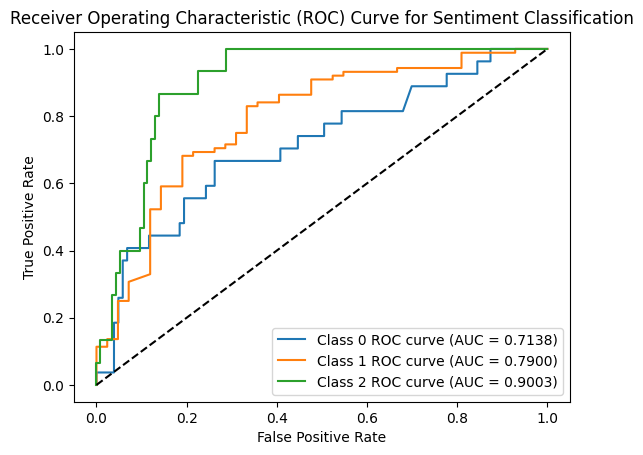

In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Function to calculate probabilities and AUC scores for sentiment model
def get_sentiment_probabilities_and_auc(model, dataloader, num_classes=3):
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_masks, labels, sentiments = batch
            inputs = {
                "input_ids": input_ids.to("cuda"),
                "attention_mask": attention_masks.to("cuda")
            }

            # Set up sentiment labels
            inputs["labels"] = sentiments.to("cuda")

            # Get model outputs and probabilities
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)  # Get class probabilities
            all_probs.append(probs.cpu().numpy())
            all_labels.append(sentiments.cpu().numpy())

    # Flatten the lists of probabilities and labels
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)

    return all_probs, all_labels

# Function to plot ROC curve for sentiment classification
def plot_sentiment_roc_curve(all_probs, all_labels, num_classes=3):
    fpr, tpr, aucs = {}, {}, {}

    # For each class, calculate the ROC curve and AUC
    for i in range(num_classes):
        # Calculate ROC curve and AUC for the class
        fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])  # One-vs-rest approach
        aucs[i] = roc_auc_score(all_labels == i, all_probs[:, i])  # AUC score for class i
        plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve (AUC = {aucs[i]:.4f})')

    # Plot diagonal line (chance level)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Sentiment Classification')
    plt.legend(loc="lower right")
    plt.show()

# Example usage
# Get probabilities and AUC scores for the sentiment model
sentiment_all_probs, sentiment_all_labels = get_sentiment_probabilities_and_auc(sentiment_model, test_loader, num_classes=3)

# Plot the ROC curve for sentiment classification
plot_sentiment_roc_curve(sentiment_all_probs, sentiment_all_labels, num_classes=3)


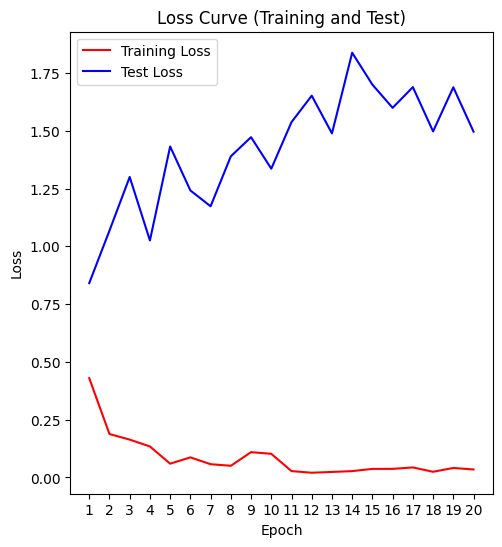

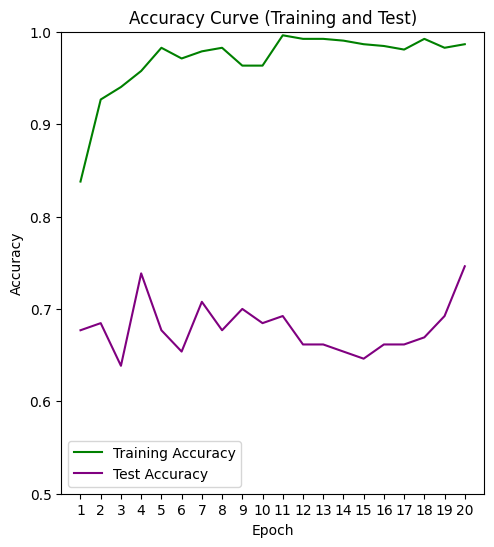

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
'''
def train_and_evaluate_model(model, train_loader, test_loader, optimizer, num_epochs=3):
    # Initialize lists to store loss and accuracy values for both train and test
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        correct_train_preds, total_train_preds = 0, 0

        # Training loop
        for batch in train_loader:
            input_ids, attention_masks, labels, sentiments = batch
            inputs = {
                "input_ids": input_ids.to("cuda"),
                "attention_mask": attention_masks.to("cuda"),
                "labels": sentiments.to("cuda")
            }

            optimizer.zero_grad()

            # Forward pass
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits

            # Backward pass
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            preds = torch.argmax(logits, dim=-1)
            correct_train_preds += (preds == sentiments.to("cuda")).sum().item()
            total_train_preds += len(preds)

            # Accumulate training loss
            epoch_train_loss += loss.item()

        # Calculate average training loss and accuracy
        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_train_accuracy = correct_train_preds / total_train_preds

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        # Evaluate on test set after each epoch
        model.eval()
        epoch_test_loss = 0
        correct_test_preds, total_test_preds = 0, 0

        with torch.no_grad():
            for batch in test_loader:
                input_ids, attention_masks, labels, sentiments = batch
                inputs = {
                    "input_ids": input_ids.to("cuda"),
                    "attention_mask": attention_masks.to("cuda"),
                    "labels": sentiments.to("cuda")
                }

                # Forward pass on the test set
                outputs = model(**inputs)
                loss = outputs.loss
                logits = outputs.logits

                # Calculate accuracy
                preds = torch.argmax(logits, dim=-1)
                correct_test_preds += (preds == sentiments.to("cuda")).sum().item()
                total_test_preds += len(preds)

                # Accumulate test loss
                epoch_test_loss += loss.item()

        # Calculate average test loss and accuracy
        avg_test_loss = epoch_test_loss / len(test_loader)
        avg_test_accuracy = correct_test_preds / total_test_preds

        test_losses.append(avg_test_loss)
        test_accuracies.append(avg_test_accuracy)

        # Print epoch results
        print(f"Epoch {epoch + 1}/{num_epochs} - "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f} - "
              f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}")

    return train_losses, train_accuracies, test_losses, test_accuracies

# Example usage: train your model and track the loss and accuracy for both train and test
train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate_model(
    sentiment_model, train_loader, test_loader, sentiment_optimizer, num_epochs=20
)
'''
# Plotting Training and Test Curves
def plot_training_and_test_curves(train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot loss curve
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='red')
    plt.plot(epochs, test_losses, label='Test Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve (Training and Test)')
    plt.xticks(epochs)
    plt.legend()
    plt.show()
    # Plot accuracy curve
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='green')
    plt.plot(epochs, test_accuracies, label='Test Accuracy', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve (Training and Test)')
    plt.xticks(epochs)
    plt.ylim(0.5, 1)
    plt.legend()

    plt.show()

# Call the plotting function
plot_training_and_test_curves(train_losses, test_losses, train_accuracies, test_accuracies)

